# Vislice
V tej nalogi si bomo ogledali slovenske samostalnike s strani igranja igre vislice. Izračunali bomo eno od optimalnih strategij za to igro in s pomočjo dobljenih rezultatov pogledali, kakšne besede so v teoriji najtežje za uganiti.

Po izbiri pripravite pythonovo virtualno okolje. Preden uporabljate katerekoli programe v tem repozitoriju, poženite naslednje ukaze, da naložite vse potrebne python pakete in večje datoteke, ki jih z git-om morda niste:

In [ ]:
!pip install -r requirements.txt
!python data/get_lf_no_lfs.py


## Natančnejši opis problema
### Pravila igre
V splošnem se igro igrata dve osebi. Ena oseba si izmisli besedo, druga pa ugiba njene črke. Vsakič ko črko pravilno ugotovi, se črko zapiše na njena mesta v besedi.
Če beseda ugibane črke ne vsebuje, oseba, ki ugiba, izgubi življenje. To se ponavadi označi tako, da druga oseba nariše eno črto na skico obešenega človeka.
Ko je slika končana, je igre konec in zmaga tisti, ki si je besedo izmislil. Če ugotovi vse črke v besedi, zmaga tisti, ki ugiba.

To je splošen opis igre, ki še vedno dopušča mnogo variacij. Za potrebe te naloge se bomo odločili za nekaj točnejših pravil:
* Izbrana beseda je na seznamu besed, ki je znan vnaprej, to so vsi samostalniki iz SSKJ, ki vsebujejo le črke slovenske abecede. Shranjeni so v `data/nouns_si.txt`.
* Male in velike črke uporabljamo za iste črke.
* Ko ugibamo, na začetku poznamo dolžino besede, prvo črko in kje vse se ta črka ponovi.
* Z vidika naloge je število poskusov ko lahko ugibamo nepomembno, zato števila življenj ne bomo določili.

### Optimalna strategija
Kaj je optimalna se lahko spreminja glede na naše potrebe. Za naše potrebe bomo iskali takšno optimalno strategijo:
* Z vsako strategijo bomo pri eni ali več besedah porabili največje število življenj. Če ugibamo to besedo je to najslabši možen primer.
* Strategija je optimalna, če ima v primerjavi z ostalimi strategijami po njihovih najslabših možnih primerih najmanjše število porabljenih življenj.
* Opazovali bomo samo najslabši možen primer. Če imata dve strategiji enako slab najslabši primer, sta enako dobri. Tudi če ena od strategij vse ostale besede reši
z manj izgubljenimi življenji, sta še vedno enako dobri.
* Za strategijo nas zanima število izgubljenih življenj, da uganemo besedo v najslabšem možnem primeru. Zato v pravilih ni smiselno določiti po koliko napakah je igre konec.
* Optimalnih strategij je lahko več. Ponavadi jih je celo zelo veliko. 
(Če imamo vzorec "se_" - prvi črki sta "s" ter "e" in ugibamo še tretjo, potem imamo na voljo 10 črk ki dajo besedo in kar 3628800 različnih strategij!)

Ker obstaja veliko različnih optimalnih strategij, ne moremo povedati veliko o tem, kako izgledajo. V izračunu strategije se izmed vseh izračuna tista, ki čim prej uporabi najbolj pogosto črko. Najbolj pogosta črka v tem primeru pomeni, da med vsemi preostalimi besedami preštejemo vse ponovitve vsake črke (če se v besedi črka ponovi večkrat, se šteje večkrat) in ta, ki se je ponovila največkrat, je najbolj pogosta. Iz tega razloga bi lahko primerjali optimalno strategijo z naivno strategijo, kjer vedno vzamemo najbolj pogosto možno črko.

### Seznam besed
Vir besed je stran [https://fran.si/iskanje?FilteredDictionaryIds=130&View=1&Query=%2A](https://fran.si/iskanje?FilteredDictionaryIds=130&View=1&Query=%2A). 
Program `src/collector/sskj_collector.py` prebere število strani z besedami in pobere besede z vsake izmed njih. Ima tudi možnost, da se omeji samo na samostalnike.
Potem popravi še vsa naglasna znamenja v navadne črke in pobriše besede ki ne vsebujejo samo slovenskih črk. Na koncu jih uredi po slovenski abecedi. Besede na tej točki ohranijo morebitne velike začetnice, ki se pa med računanjem strategije ne upoštevajo.

Besede so že shranjene v datoteki [data/nouns_si.txt](../data/nouns_si.txt), zato jih ni potrebno ponovno nalagati.
Če želite pognati pobiranje besed lahko to storite s pomočjo skripte z ukazom (postopek traja, ker prebere več kot 4600 strani):

In [115]:
%run vislice.py sskjcollect --help

usage: vislice.py sskjcollect [-h] [--limit LIMIT] [--threads THREADS]
                              [--noprogress] [--file FILE] [--raw]
                              [--nounsonly]

options:
  -h, --help         show this help message and exit
  --limit LIMIT      limit the number of pages to collect words from (default:
                     all)
  --threads THREADS  maximum number of threads to use (default: 100)
  --noprogress       show progress while collecting words (default)
  --file FILE        file to save words to (default: data/sskj_words.txt)
  --raw              by default it removes accents, special characters, ...
  --nounsonly        collect only nouns


In [ ]:
%run vislice.py sskjcollect --file data/samostalniki.txt --nounsonly

### Izračun optimalne strategije
Glede na podan seznam besed program `src/solver/game.py` izračuna najboljšo možno strategijo tako, da sledi korakom:
* Če se v že ugibanih črkah besede ne ujemajo, jih razdelimo na skupine, tako da glede na te črke izgledajo enako. Za vsako skupino izračunamo strategijo posebej in naša strategija ima
toliko napak kot jih ima skupina z največ napakami.
* Če smo besedo uganili, smo zanjo že zmagali. Strategija ima 0 korakov in naredimo 0 napak.
* Če si vse možne besede delijo kakšno črko, ugibamo te črke. Besede razdelimo v skupine, tako da imajo ugibane črke na istih mestih in za vsako od dobljenih skupin
izračunamo najboljšo strategijo. Strategija ima toliko napak kot skupina z največ napakami.
* Za vsako črko, ki je še nismo ugibali, od najbolj do najmanj pogoste poskusimo:
    - Besede razdelimo v skupine, tako da se ujemajo v vseh do zdaj ugibanih črkah in v tej izbrani črki.
    - Izračunamo strategijo za vse skupine. Če besede v tej skupini ne vsebujejo izbrane črke, ima skupina eno napako več kot njena strategija.
    Če besede v skupini vsebujejo črko, ima skupina toliko napak, kot ima napak njena strategija.
    - Za najboljšo strategijo vzamemo črko, ki ima pri najslabši skupini najmanjše število napak.
Na koncu dobimo eno izmed najboljših strategij. Strategija je že izračunana in shranjena v [data/nouns_si_strategy_hinted.json](../data/nouns_si_strategy_hinted.json)

Če želite poračunati strategijo lahko to storite s pomočjo ukaza spodaj. (Zelo traja - lahko tudi več kot 8 ur, poraba pomnilnika je do 3 GB.) Spremenite `data/nouns_si.txt`, če želite drug seznam besed.

In [116]:
%run vislice.py hintstrat --help

usage: vislice.py hintstrat [-h] [--output OUTPUT] [--limit LIMIT] words

positional arguments:
  words            file with words to find strategy for

options:
  -h, --help       show this help message and exit
  --output OUTPUT  file to save strategy to (default: data/hstrategy.json)
  --limit LIMIT    limit the number of words to find strategy for (default:
                   all)


In [ ]:
%run vislice.py hintstrat data/nouns_si.txt --output data/strategija.json

## Analiza podatkov


In [1]:
%load_ext autoreload
%autoreload 2

import json

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

from src.analysis import utils

In [2]:
with open("data/nouns_si_strategy_hinted.json", encoding="utf-8") as f:
    strategy_object = json.load(f)

words = pd.array(strategy_object["words"])
strategies = strategy_object["strategies"]

Za začetek preberemo seznam dovoljenih besed:

In [3]:
words

<StringArray>
[        'abak', 'abalienacija',         'abbe',      'abderit',
  'abderitstvo',   'abdikacija',      'abdomen',    'abdukcija',
      'abeceda',     'abecedar',
 ...
      'žvižgač',    'žvižganje',    'žvižgavec',    'žvižgavka',
       'žvokno',   'žvrgolenje',  'žvrgolevček',      'žvrkelj',
      'žvrklja',   'žvrkljanje']
Length: 49909, dtype: string

Za vsako besedo vzamemo prvo črko in pogledamo kje vse se ponovi. Tako dobimo vzorec, ki mu lahko sledi ena ali več besed. Vsak od takih vzorcev nam predstavlja isto izhodišče za igranje igre. Tukaj se naložijo osnovni podatki za takšne skupine.

In [4]:
strategies_info = pd.json_normalize(
    [
        {"pattern": " ".join(key), "words_count": len(value["words"]), "worst_case_mistakes": value["max_errors"]}
        for key, value in strategies.items()
    ]
)
strategies_info

,pattern,words_count,worst_case_mistakes
0,a _ a _,6,4
1,a _ a _ _ _ _ a _ _ _ a,1,0
2,a _ _ _,30,5
3,a _ _ _ _ _ _,80,3
4,a _ _ _ _ _ _ _ _ _ _,30,1
...,...,...,...
2412,ž _ ž _ _ _ _ _ _ _ _,3,0
2413,ž _ ž _ _ _ _ _ _,2,0
2414,ž _ _ ž _,1,0
2415,ž _ _ ž _ _ _,1,0


S temi podatki o strategijah lahko odgovorimo na dve zelo zanimivi vprašanji: 
- Kdaj (če nimamo sreče) lahko pričakujemo da se bomo zmotili največkrat?
- Kdaj lahko zmagamo brez da se zmotimo?

In [5]:
worst = strategies_info[strategies_info["worst_case_mistakes"] == strategies_info["worst_case_mistakes"].max()]
worst

,pattern,words_count,worst_case_mistakes
1023,k _ _ _,117,10
1159,l _ _,35,10


Iz zgornje tabele lahko vidimo da sta najslabša možna začetka "k _ _ _" in "l _ _". Gre za skupine relativno kratkih besed, kar je pričakovano, saj poznamo 1. črko, izmed ostalih 24 v abecedi pa moramo pravilno uganiti 2 ali 3. Če o besedah ne bi vedeli ničesar, bi lahko v takšnem primeru pričakovali 22 ali pa 21 napak. Zdaj vemo tudi, da če imamo na voljo vsaj 11 življenj, lahko igro vislic zmagamo vedno (pri postavljenih pravilih).

Najboljših možnih začetkov je več kot najslabših. 

In [6]:
best = strategies_info[strategies_info["worst_case_mistakes"] == strategies_info["worst_case_mistakes"].min()]
print(f"Number of best possible starts: {len(best["words_count"])}")
print(f"Number of words that give a best possible start: {best["words_count"].sum()}")
print(f"Number of starts where only one word is possible: {len(best[best["words_count"] == 1])}")

best[best["words_count"] > 1].reset_index()

Number of best possible starts: 1523
Number of words that give a best possible start: 3272
Number of starts where only one word is possible: 861


,index,pattern,words_count,worst_case_mistakes
0,22,a _ _ _ _ _ _ _ _ _ _ _,20,0
1,30,a _ _ _ _ _ _ _ _ a _ _ _ a,7,0
2,32,a _ _ _ _ _ _ _ a _ _ _,7,0
3,35,a _ _ _ _ a _ _ _ _ _,13,0
4,36,a _ _ _ _ a _ _ _ _ _ _,2,0
...,...,...,...,...
657,2407,ž _ _ _ _ _ _ _ _ _ _ _ _ _ _,3,0
658,2410,ž _ ž _ _ _ _,2,0
659,2412,ž _ ž _ _ _ _ _ _ _ _,3,0
660,2413,ž _ ž _ _ _ _ _ _,2,0


Iz zgornje celice dobimo odgovor na drugo vprašanje. Brez da se zmotimo lahko zmagamo v 1523 primerih, od tega lahko v 861 primerih takoj uganemo besedo. Prej smo že ugotovili, da imamo pri izbranem seznamu 49909 besed 2417 možnih začetkov. Garantirano zmago nam da 3272 besed, ampak to ne pomeni, da je to število besed, ki jih lahko uganemo brez napak. Z uporabo izračunane strategije pri vsakem začetku lahko nekatere besede ugotovimo brez napak. Izračunati čim več besed brez da kdaj zgrešimo črko ni bilo postavljeno merilo za optimalno strategijo, zato te statistike nima smisla vključiti v rezultate, saj bi lahko imeli drugo optimalno strategijo, ki bi dala drugačne rezultate.

### Slabi začetki
Zdaj že vemo kakšna sta najslabša možna začetka. Če igramo vislice proti nekomu in smo mi izbrali besedo, nam pa to še ne pomaga preveč. Zanima nas, katere besede si moramo izbrati, da bo naš nasprotnik najbolj trpel, tudi če je robot in igra optimalno. Najprej poglejmo, katere so besede, ki se ujemajo z vzorcema najslabših primerov.

In [7]:
worst_words1 = strategies["l__"]["words"]
print(worst_words1)
worst_words2 = strategies["k___"]["words"]
print(worst_words2)

['laj', 'lak', 'lan', 'lar', 'las', 'lat', 'laz', 'laž', 'led', 'lej', 'lek', 'lep', 'les', 'leš', 'let', 'lev', 'lij', 'lik', 'lim', 'liv', 'lob', 'loč', 'log', 'loj', 'lok', 'lom', 'lon', 'los', 'lot', 'lov', 'lož', 'lub', 'luč', 'lug', 'luk']
['kača', 'kadi', 'kaja', 'kala', 'kalo', 'kamp', 'kana', 'kanu', 'kaos', 'kapa', 'kapo', 'kare', 'karo', 'karp', 'kart', 'kasa', 'kaša', 'kava', 'kavč', 'kavs', 'keha', 'kela', 'kepa', 'kila', 'kilt', 'kinč', 'kino', 'kist', 'kita', 'kivi', 'klan', 'klas', 'kleč', 'klej', 'klen', 'klep', 'kler', 'klet', 'klic', 'klin', 'klob', 'klon', 'klop', 'klor', 'klot', 'klub', 'kmet', 'knap', 'knez', 'knof', 'koca', 'koča', 'koda', 'kofe', 'koja', 'kola', 'kolc', 'kolč', 'kolo', 'kolt', 'koma', 'komi', 'konj', 'kopa', 'kord', 'korm', 'kosa', 'kost', 'kota', 'koza', 'koža', 'krah', 'kraj', 'krap', 'kras', 'krat', 'kreč', 'kreg', 'krep', 'kres', 'krez', 'krič', 'križ', 'krlj', 'krma', 'krof', 'krog', 'kroj', 'krom', 'krop', 'kros', 'krov', 'krpa', 'krst', '

Niso pa vse te besede najbolj zlobna izbira. Natančno si poglejmo zakaj in katere izmed teh besed se splača izbrati.

In [8]:
def group_by_letter(words, letter_indices):
    groups = pd.DataFrame(words).groupby(lambda i: tuple(words[i][j] for j in letter_indices)).groups
    maxlen = max(map(len, groups.values()))
    return pd.DataFrame(
        ([words[group.values[i]] if len(group.values) > i else "" for group in groups.values()] for i in range(maxlen)),
        columns=map(" ".join, groups.keys()),
    )


group_by_letter(worst_words1, letter_indices=(1,))

,a,e,i,o,u
0,laj,led,lij,lob,lub
1,lak,lej,lik,loč,luč
2,lan,lek,lim,log,lug
3,lar,lep,liv,loj,luk
4,las,les,,lok,
5,lat,leš,,lom,
6,laz,let,,lon,
7,laž,lev,,los,
8,,,,lot,
9,,,,lov,


In [9]:
df = group_by_letter(worst_words2, letter_indices=(1, 3))
df.loc[:, df.iloc[2] != ""]  # Too many columns, select only those with at least 3 words.

,a a,a o,e a,l n,o a,r j,r p,r s,u a
0,kača,kalo,keha,klan,koca,kraj,krap,kras,kuba
1,kaja,kapo,kela,klen,koča,krlj,krep,kres,kuga
2,kala,karo,kepa,klin,koda,kroj,krop,kros,kuha
3,kana,,,klon,koja,,krup,,kula
4,kapa,,,,kola,,,,kuma
5,kasa,,,,koma,,,,kuna
6,kaša,,,,kopa,,,,kupa
7,kava,,,,kosa,,,,kura
8,,,,,kota,,,,kuta
9,,,,,koza,,,,kuža


S tako zapisanimi besedami je precej očitno, zakaj v tej skupini ne moremo v najslabšem primeru porabiti manj kot 10 poskusov. V prvi tabeli so zares najslabše besede besede v stolpcu "o" - tiste, ki se začnejo na "lo", v drugi tabeli pa besede v stolpcu "oa". Tema seznamoma besed je skupno, da imata 11 različnih besed, ki se razlikujejo le v eni črki na enem mestu. V najslabšem primeru se bomo 10-krat zmotili in glede tega ne moremo storiti ničesar.

To sta bila najslabša možna začetka, poglejmo še nekaj drugih slabih.

In [10]:
bad_starts = (
    strategies_info[strategies_info["worst_case_mistakes"] >= 7]
    .sort_values("worst_case_mistakes", ascending=False)
    .reset_index(drop=True)
)
bad_starts

,pattern,words_count,worst_case_mistakes
0,l _ _,35,10
1,k _ _ _,117,10
2,k _ _,37,9
3,b _ _,35,9
4,k _ _ _ _,267,9
5,r _ _ _,74,9
6,s _ _,35,9
7,v _ _ _,84,9
8,r _ _,38,9
9,m _ _,33,8


Poglejmo, če lahko tudi za te skupine besed najdemo tako enostaven razlog za rezultate, kot smo ga za najslabši skupini.

In [11]:
df = pd.DataFrame(
    [
        {
            "pattern": pattern,
            "words": " ".join(utils.largest_1_letter_away_group(strategies[pattern.replace(" ", "")]["words"])),
        }
        for pattern in bad_starts["pattern"]
    ]
)
df.insert(2, "mistakes", bad_starts["worst_case_mistakes"])
df.insert(3, "words_1_letter_away", df["words"].apply(lambda words: words.count(" ") + 1))
df.insert(
    4,
    "easy_to_explain",
    (df["words_1_letter_away"] - df["mistakes"]).apply(lambda x: "yes" if x == 1 else "even worse" if x > 1 else ""),
)
df

Found alternative groups of size 5 for ['obal', 'ogal', 'opal', 'oral', 'oval']: [['ogel', 'okel', 'opel', 'orel', 'osel']]
Found alternative groups of size 8 for ['pica', 'piča', 'pika', 'pila', 'pira', 'pisa', 'pita', 'piva']: [['plac', 'plač', 'plak', 'plam', 'plan', 'plat', 'plav', 'plaz']]
Found alternative groups of size 5 for ['pajček', 'palček', 'parček', 'pašček', 'pavček']: [['pečica', 'pegica', 'penica', 'perica', 'petica'], ['prahec', 'pralec', 'pramec', 'prasec', 'pravec']]
Found alternative groups of size 4 for ['nabod', 'nahod', 'narod', 'navod']: [['nabor', 'napor', 'navor', 'nazor'], ['naliv', 'nariv', 'našiv', 'naziv'], ['namok', 'napok', 'narok', 'natok'], ['navod', 'navoj', 'navor', 'navoz']]
Found alternative groups of size 6 for ['siga', 'sika', 'sila', 'sima', 'sipa', 'sita']: [['soba', 'soda', 'soha', 'soja', 'sora', 'sova']]
Found alternative groups of size 5 for ['sobar', 'sodar', 'solar', 'sonar', 'sopar']: [['stega', 'stela', 'stena', 'stepa', 'steza']]
Foun

,pattern,words,mistakes,words_1_letter_away,easy_to_explain
0,l _ _,lob loč log loj lok lom lon los lot lov lož,10,11,yes
1,k _ _ _,koca koča koda koja kola koma kopa kosa kota k...,10,11,yes
2,k _ _,koc koč kod kol kop kor kos koš kot kov,9,10,yes
3,b _ _,boa bod bog boh boj bok bol bon bor bos,9,10,yes
4,k _ _ _ _,kočar kolar komar kopar kosar košar kotar kova...,9,10,yes
5,r _ _ _,rega reja reka rena repa resa reta reva reza reža,9,10,yes
6,s _ _,seč sed sef sek sel sen sep ser set sev,9,10,yes
7,v _ _ _,veča veda veha veja veka vena vera vesa veza veža,9,10,yes
8,r _ _,rob roč rod rog roj rok rom rop rov,9,9,
9,m _ _,moa mob moč mok mol mop mor mož,8,8,


Stolpec "easy_to_explain" ima vrednost "yes" kjer se je zgodil enak primer kot za najslabša možna začetka. V vseh teh primerih se je zgodilo, da obstaja neka skupina besed (stolpec "words"),
v kateri se besede paroma razlikujejo le v eni črki na enem mestu. Prav tako se te črke ne pojavijo nikjer kjer se besede ujemajo. Enak primer kot za najslabša začetka se je zgodil v primerih, kjer ima opisana skupina eno besedo več kot maksimalno število napak. Stolpec "words_1_lettre_away" vsebuje največje število besed, ki se paroma razlikujejo v natanko eni črki na enem mestu.

V stolpcu "words" so tiste besede, ki se paroma razlikujejo v eni črki na enem mestu. Število teh besed je stolpec "words_1_letter_away". Nad tabelo so izpisane še druge najdene take skupine besed, ki namigujejo na razloge zakaj so težke za uganiti. Točen razlog je zanje težje določiti in tega v tej analizi ne bo.

### Dobri začetki
Dobri začetki - tisti začetki, kjer si lahko zagotovimo zmago v malo potezah, nas zanimajo v dveh oblikah. Eni so manj zanimivi, to so tisti, kjer že iz začetnega namiga lahko zožimo možne besede na zelo majhno množico. Malo bolj zanimivi so tisti, ki dopuščajo veliko besed, pa se nam kljub temu ni treba velikokrat zmotiti.

In [12]:
strategies_info[(strategies_info["worst_case_mistakes"] == 0) & (strategies_info["words_count"] > 12)].reset_index(drop=True)

,pattern,words_count,worst_case_mistakes
0,a _ _ _ _ _ _ _ _ _ _ _,20,0
1,a _ _ _ _ a _ _ _ _ _,13,0
2,f _ _ _ _ _ _ _ _ _ _ _ _ _,16,0
3,i _ _ _ _ _ _ _ _ i _ _,15,0
4,i _ _ _ _ _ _ _ _ _ _ _ _,27,0
5,k _ _ _ _ _ _ _ _ _ _ _ _ _ _ _,13,0
6,n _ _ _ _ _ _ _ _ _ _ n _ _ _,13,0
7,o _ _ _ _ o _ _ _ _ _ _ _,13,0
8,s _ _ _ _ _ _ _ _ _ _ _ s _,17,0
9,s _ _ _ _ _ _ _ _ _ _ _ _ _ _,31,0


In [13]:
strategies_info[(strategies_info["worst_case_mistakes"] <= 3) & (strategies_info["words_count"] > 300)].reset_index(drop=True)

,pattern,words_count,worst_case_mistakes
0,b _ _ _ _ _ _ _,344,3
1,d _ _ _ _ _ _ _,341,3
2,d _ _ _ _ _ _ _ _,358,3
3,k _ _ _ _ _ _ _ _ _,305,2
4,k _ _ _ _ _ _ _ _,357,3
5,m _ _ _ _ _ _ _,360,3
6,p _ _ _ _ _ _ _ _ _ _ _,526,2
7,p _ _ _ _ _ _ _ _ _,946,3
8,p _ _ _ _ _ _ _ _ _ _,666,2
9,p _ _ _ _ _ _ _ _ _ _ _ _,312,2


V zgornjih dveh tabelah lahko vidimo nekaj začetkov, ki se za nas, če igramo pametno, ko ugibamo, vedno dobro izidejo. Tabeli sta dobri, da nam dasta nekaj občutka, iz kolikšne skupine besed lahko še vedno z malo napakami pridemo do iskane besede. 

Besede izgledajo daljše kot pri slabih začetkih. Ta in podobne statistične povezave med težavnostjo besed in njihovo obliko spadajo v naslednje poglavje.

### Statistika
V poglavju o slabih začetkih smo se lahko naučili izmed katerih besed izbirati, če hočemo da nasprotnik trpi ko ugiba. Če je 10 ali pa 20 besed preveč, da si jih zapomnimo, pa si v tem poglavju poglejmo nekaj bolj statističnih podatkov.

Ena najbolj očitnih lastnosti, ki vplivajo na težavnost napisanega začetka, je število besed, ki se z začetnim vzorcem ujemajo:

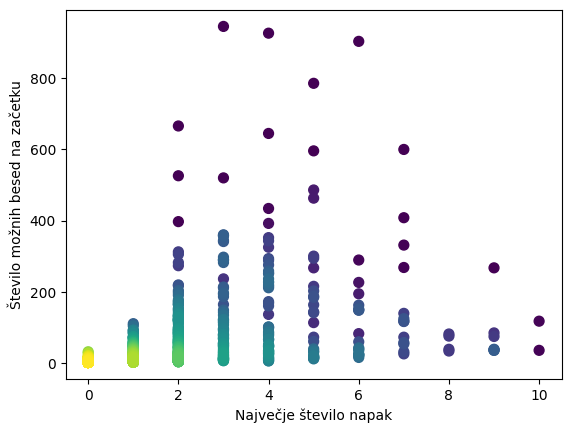

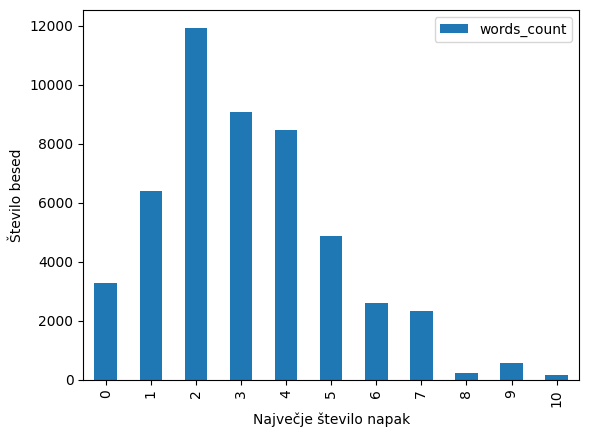

In [14]:
x = strategies_info["worst_case_mistakes"]
y = strategies_info["words_count"]

# Calculate the point density
xy = np.vstack([x, y])
z = np.log(gaussian_kde(xy)(xy))
z = np.sqrt(z - z.min() + 1)

# Sort the points by density, so that the densest points are plotted last - on top
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
plt.xlabel("Največje število napak")
plt.ylabel("Število možnih besed na začetku")
plt.show()

ax = strategies_info.groupby("worst_case_mistakes").sum().plot(kind="bar", y="words_count")
ax.set_xlabel("Največje število napak")
_ = ax.set_ylabel("Število besed")

Zgornji graf pričakovano pokaže, da če moramo ugibati med veliko besedami, bomo večkrat naredili veliko napak. Nekoliko presenetljivo, pa ugibanje med zelo veliki skupinami besed ne povzroči najslabših rezultatov. Če pogledamo še spodnji graf, lahko vidimo skupno število besed, ki dajo začetni vzorec, ki se konča v določenem največjem številu napak. Zelo slabi primeri se zgodijo le pri majhnem številu besed, kar je verjetno razlog da med njimi ni zelo velikih skupin. Če pogledamo barve - bolj rumena, bolj goste so pike, opazimo tudi, da v splošnem velja povezava, da manjša skupina pomeni manj napak. Zelo velike skupine, pa izgleda, da ne morejo imeti ene ali pa dveh napak, več pa lahko.

Naslednja zanimiva povezava bi lahko bila dolžina besed in njihova težavnost.

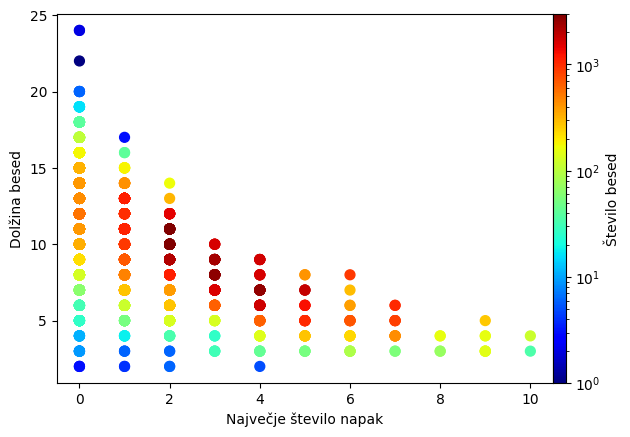

In [15]:
x = strategies_info["worst_case_mistakes"]
y = strategies_info["pattern"].apply(lambda x: x.count(" ") + 1)


# Calculate the point density
counts = {}
for i, j, m in zip(x, y, strategies_info["words_count"]):
    counts[(i, j)] = counts.get((i, j), 0) + m
z = np.array([counts[(i, j)] for i, j in zip(x, y)])

normalize = mcolors.LogNorm(vmin=z.min(), vmax=z.max())
colormap = cm.jet

fig, ax = plt.subplots()
plt.scatter(x, y, c=colormap(normalize(z)), s=50)
plt.xlabel("Največje število napak")
plt.ylabel("Dolžina besed")
ax_pos = ax.get_position()
sub_ax = plt.axes([ax_pos.x1, ax_pos.y0, 0.02, ax_pos.height])
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(z)
plt.colorbar(scalarmappaple, cax=sub_ax)
sub_ax.set_ylabel("Število besed")
plt.show()

Med največjim številom napak in dolžino besed lahko opazimo zelo lepo povezavo. Daljša kot je beseda, lažje jo je uganiti, to velja vsaj za besede daljše od 5 znakov. Besede dolge 2 znaka je lahko uganiti - to kaže spodnja vrstica pik. To je verjetno posledica tega, da takih besed ni veliko. Iz podatkov lahko sklepamo, da jih je največ 5 z isto začetno črko, saj se v najslabšem primeru zmotimo 4-krat, ko ugibamo 1 črko pa nimamo na voljo nobene pametne strategije. Iz barv lahko ugotovimo tudi, da so besede bolj zgoščene stran od težkih in lahkih ter dolgih in kratkih.

Začetni namigi se razlikujejo po dolžini besede, koliko besed takoj izločijo, katera je namignjena črka in kje vse se črka ponovi. Prvi dve lastnosti smo že pogledali, ostaneta še dve. Najprej si oglejmo, kako število ponovitev začetne črke vpliva na težavnost besede.

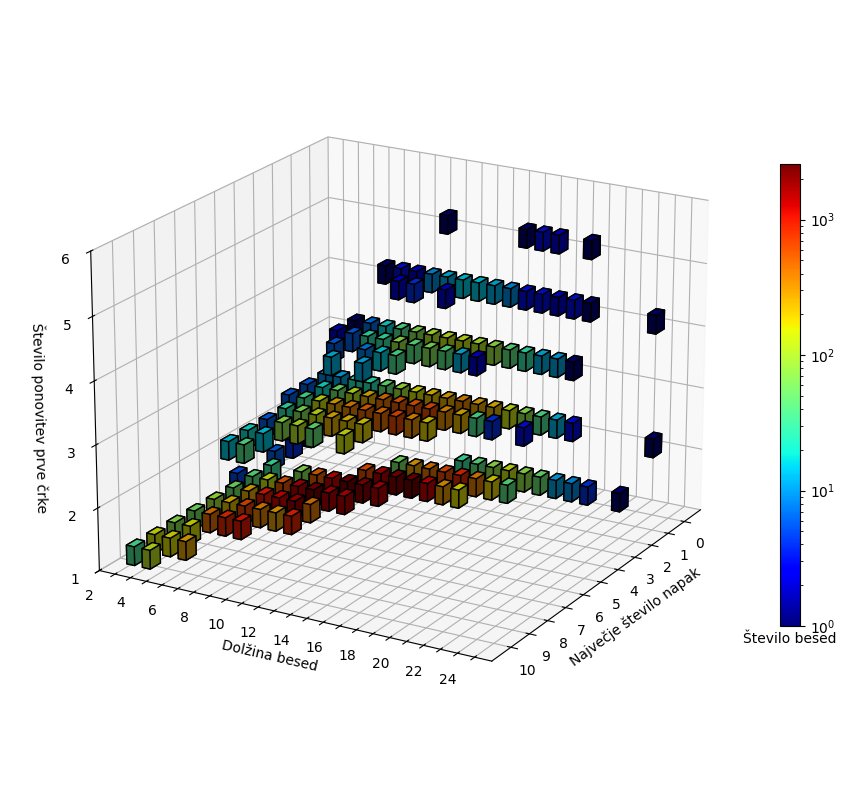

In [43]:
voxels = {}  # (mistakes = x, len = y, first letter count = z) -> (words count = color)
for i, row in strategies_info.iterrows():
    pattern = row["pattern"]
    key = (row["worst_case_mistakes"], pattern.count(" ") + 1, pattern.count(pattern[0]))
    voxels[key] = voxels.get(key, 0) + row["words_count"]

norm = mcolors.LogNorm(vmin=min(voxels.values()), vmax=max(voxels.values()))
cmap = cm.jet

x, y, z = zip(*voxels.keys())
mx, my, mz = max(x) + 1, max(y) + 1, max(z) + 1
filled = np.zeros((mx, my, mz), dtype=bool)
colors = np.zeros((mx, my, mz, 4))
for key, value in voxels.items():
    filled[key] = True
    colors[key] = cmap(norm(value))

filled = utils.explode(filled)
colors = utils.explode(colors)

x, y, z = np.indices(np.array(filled.shape) + 1).astype(float) // 2
x[0::2, :, :] -= 0.25
y[:, 0::2, :] -= 0.25
z[:, :, 0::2] -= 0
x[1::2, :, :] += 0.25
y[:, 1::2, :] += 0.25
z[:, :, 1::2] += 0.3


def plot_this(azim=30):
    ax = plt.figure(figsize=(10, 10)).add_subplot(projection="3d")
    ax.voxels(x, y, z, filled, facecolors=colors, edgecolor="k")
    ax.view_init(elev=20, azim=azim, roll=0)

    ax.set_box_aspect(None, zoom=0.9)
    ax.set_zlim(1, 6)
    ax.set_yticks(range(2, 26))
    ax.set_ylim(2, 26)
    for ylabel in ax.yaxis.get_ticklabels()[1::2]:
        ylabel.set_visible(False)
    ax.set_xticks(range(0, 11))
    ax.set(xlabel="Največje število napak", ylabel="Dolžina besed", zlabel="Število ponovitev prve črke")

    ax_pos = ax.get_position()
    sub_ax = plt.axes([ax_pos.x1, ax_pos.y0 + ax_pos.height * 0.2, 0.02, ax_pos.height * 0.6])
    scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
    scalarmappaple.set_array(np.array(list(voxels.values()), dtype=float))
    plt.colorbar(scalarmappaple, cax=sub_ax)
    sub_ax.set_xlabel("Število besed")

    plt.show()


# comment / uncomment the next 2 lines to enable / disable rotation
# _ = interact(plot_this, azim=(0, 360, 10))
plot_this()

Kot lahko vidimo ima število ponovitev prve črke močno povezavo s težavnostjo besed. To lahko hitro vidimo, če opazimo, da višji kot je nivo (več ponovitev prve črke kot imajo besede), manjše je največje število napak. Maksimalno največje število napak za besede z enkrat ponovljeno črko je 6, za besede z dvakrat ponovljeno 3, trikrat 1 in štirikrat 0. Še vedno približno velja vzorec, da je daljše besede (in najkrajše) lažje uganiti kot krajše. Opazimo lahko pa še eno zanimivo povezavo, to je "luknja" okrog točke (0, 0, 0) na spodnjem nivoju. To pomeni, da je kratke besede, v katerih se prva črka ne ponovi kasneje, zelo težko ugotoviti. Zelo težko ugotoviti v tem primeru pomeni, da ne obstaja začetek, pri katerem bi lahko vsako besedo uganili z majhnim številom napak.

In [48]:
letters = "abcčdefghijklmnoprsštuvzž"
table = pd.DataFrame(np.array([[0] * len(letters)] * 11), columns=list(letters))
for i, row in strategies_info.iterrows():
    col = row["pattern"][0]
    v = row["words_count"]
    table.loc[row["worst_case_mistakes"], col] += v
table.rename_axis("Največje število napak", inplace=True)
table.loc["Total"] = table.sum()
table

,a,b,c,č,d,e,f,g,h,i,j,k,l,m,n,o,p,r,s,š,t,u,v,z,ž
Največje število napak,,,,,,,,,,,,,,,,,,,,,,,,,
0,262,97,76,46,127,217,72,80,30,274,59,145,82,101,292,185,134,163,305,45,224,38,126,67,25
1,409,143,70,77,316,278,245,106,107,361,116,417,79,263,537,419,403,377,621,56,322,117,318,165,84
2,397,303,228,190,401,148,210,454,306,504,184,812,316,387,719,411,2063,717,1067,240,437,344,321,609,165
3,228,841,158,285,999,128,220,297,282,246,162,507,186,650,273,171,1013,426,597,306,308,86,502,0,200
4,108,343,101,115,540,44,94,494,227,113,66,551,371,392,443,582,927,26,645,168,486,133,514,895,95
5,30,587,46,0,163,0,39,141,0,46,0,486,0,294,0,500,786,0,1059,129,244,143,187,0,0
6,15,0,0,22,84,0,0,23,0,0,55,0,148,194,0,201,904,666,0,82,0,0,0,190,0
7,0,0,0,0,0,0,0,72,0,0,0,408,57,0,124,0,1047,0,407,0,31,53,25,117,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,108,0,81,38,0,0,0,0,0,0,0,0


In [52]:
pd.set_option("display.max_columns", None)
table_rel = table.div(table.loc["Total"])

words_joined = "".join(set(map(str.lower, strategy_object["words"])))
letter_frequencies = {letter: (words_joined.count(letter) / len(words_joined)) for letter in letters}
letters_oredred = sorted(letters, key=lambda x: -letter_frequencies[x])
letter_indices = {letter: i + 1 for i, letter in enumerate(letters_oredred)}

df = pd.DataFrame(table_rel.loc[6 : len(table_rel) - 2].sum().sort_values(ascending=False), columns=["Relative frequency"])
df.join(pd.Series(letter_indices, name="Frequency order"))

,Relative frequency,Frequency order
r,0.312827,6
p,0.271907,13
k,0.221244,10
l,0.188383,9
z,0.150269,17
m,0.126413,16
o,0.110588,3
s,0.093328,8
j,0.085670,11
š,0.079922,22


V prvi tabeli vidimo kako začetne črke vplivajo na največje število napak in koliko besed se na te črke pri toliko napakh začne. V drugi tabeli je le nekakšen povzetek prve, za vsako začetno črko izvemo, kolikšen delež besed nam da začetek, ki nas v najslabšem primeru pripelje do 5 napak ali več. Črke "a", "e", "ž" in "f" so najbolj in najmanj pogoste črke v slovenščini in so hkrati vse pri dnu seznama. (Ta pogostost je približna glede na besedilo, zaneslivejši vrstni red glede na črke v besedah je v stolpcu zraven.) Od ne pogostih črk je to pričakovati, saj se manj besed začne nanje in imamo lažje delo z ugibanjem. Ker sta pa "e" in "a" tudi na dnu, pa lahko sklepamo, da na to, kje in kakšne črke se pojavljajo v besedi, vplivajo začetne črke različno. Kaj točno pa to pomeni, zakaj je vrstni red črk v tabeli tak kot je, pa ne bo del te analize.

## Zaključek
Kljub omejitvam, kaj nam podatki zares povejo, smo lahko določili zares najslabše in najboljše začetke. Pogledali smo si tudi statistične podatke o tem, kako izgledajo besede, ki so potencialno najtežje za uganiti. Kot je že omenjeno na začetku, največje število napak ne pomeni, kolikokrat se bomo z optimalno strategijo zares zmotili pri nekem začetku, ampak kolikokrat se bomo v najslabšem primeru. Če kdaj uporabljate te podatke, je dobro imeti to ves čas v mislih.